In [5]:
import json
import pathlib

import pandas as pd

In [2]:
import os

print(os.getcwd())

/Users/yoangabison/Library/Mobile Documents/com~apple~CloudDocs/files/Ecole/A5/nlp_project/intents_classification


In [4]:
folder_path: pathlib.Path = pathlib.Path(
    '../nlu-benchmark/2017-06-custom-intent-engines')

In [28]:
def clean_dataset(file_path: pathlib.Path, df: pd.DataFrame) -> pd.DataFrame:
    with open(file_path.absolute(), 'r') as f:
        data = json.load(f)
        for intent, utterances in data.items():
            for utterance in utterances:
                text = ""
                for part in utterance["data"]:
                    text += part["text"]
                df = pd.concat([df, pd.DataFrame({'text': [text], 'intent': [intent]})],
                               ignore_index=True)
    return df

In [29]:
df: pd.DataFrame = pd.DataFrame(columns=['text', 'intent'])
for folder in folder_path.iterdir():
    if not folder.is_dir():
        continue
    for file in folder.iterdir():
        if file.suffix == '.json' and file.name.endswith(
                '_full.json') and file.name.startswith('train_'):
            print(file.stem)
            df = clean_dataset(file, df)

train_PlayMusic_full
train_RateBook_full
train_SearchCreativeWork_full
train_GetWeather_full
train_BookRestaurant_full
train_AddToPlaylist_full
train_SearchScreeningEvent_full


In [37]:
validation_df: pd.DataFrame = pd.DataFrame(columns=['text', 'intent'])
for folder in folder_path.iterdir():
    if not folder.is_dir():
        continue
    for file in folder.iterdir():
        if file.suffix == '.json' and file.name.startswith('validate_'):
            print(file.stem)
            validation_df = clean_dataset(file, validation_df)

validate_PlayMusic
validate_RateBook
validate_SearchCreativeWork
validate_GetWeather
validate_BookRestaurant
validate_AddToPlaylist
validate_SearchScreeningEvent


In [30]:
df

,text,intent
0,I need to hear the song Aspro Mavro from Bill ...,PlayMusic
1,play Yo Ho from the new york pops on Youtube,PlayMusic
2,Play some seventies music by Janne Puurtinen o...,PlayMusic
3,play the Música Da Série De Filmes O Hobbit al...,PlayMusic
4,Play Magic Sam from the thirties,PlayMusic
...,...,...
13779,Can a I get the movie schedule for Sympathy fo...,SearchScreeningEvent
13780,Find movie schedules for animated movies aroun...,SearchScreeningEvent
13781,what time is Bordertown Trail showing,SearchScreeningEvent
13782,in the neighbourhood find movies with movie times,SearchScreeningEvent


In [31]:
df.groupby('intent').count()

,text
intent,
AddToPlaylist,1942
BookRestaurant,1973
GetWeather,2000
PlayMusic,2000
RateBook,1956
SearchCreativeWork,1954
SearchScreeningEvent,1959


In [39]:
validation_df.groupby('intent').count()

,text
intent,
AddToPlaylist,100
BookRestaurant,100
GetWeather,100
PlayMusic,100
RateBook,100
SearchCreativeWork,100
SearchScreeningEvent,100


In [32]:
df.to_csv('data/dataset.csv', index=False)

In [33]:
df_2 = pd.read_csv('data/dataset.csv')
df_2

,text,intent
0,I need to hear the song Aspro Mavro from Bill ...,PlayMusic
1,play Yo Ho from the new york pops on Youtube,PlayMusic
2,Play some seventies music by Janne Puurtinen o...,PlayMusic
3,play the Música Da Série De Filmes O Hobbit al...,PlayMusic
4,Play Magic Sam from the thirties,PlayMusic
...,...,...
13779,Can a I get the movie schedule for Sympathy fo...,SearchScreeningEvent
13780,Find movie schedules for animated movies aroun...,SearchScreeningEvent
13781,what time is Bordertown Trail showing,SearchScreeningEvent
13782,in the neighbourhood find movies with movie times,SearchScreeningEvent


In [34]:
import datasets

In [35]:
dataset = datasets.load_dataset('csv', data_files='data/dataset.csv')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/yoangabison/.cache/huggingface/datasets/csv/default-06beae90af7cc058/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/Users/yoangabison/Library/Caches/pypoetry/virtualenvs/nlp-project-r4CxO-n--py3.10/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 13784
    })
})

In [40]:
validation_df.to_csv('data/validation_dataset.csv', index=False)

In [87]:
# Create a dataset dict with train as dataset.csv and validation as validation_dataset.csv
dataset_dict = datasets.load_dataset(
    'csv',
     data_files={
        'train': 'data/dataset.csv',
        'validation': 'data/validation_dataset.csv'
     }
)

Found cached dataset csv (/Users/yoangabison/.cache/huggingface/datasets/csv/default-d76356ad27cb26f1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

In [88]:
def label_to_int(intent) :
    if intent == 'AddToPlaylist':
        return 0
    elif intent == 'BookRestaurant':
        return 1
    elif intent == 'GetWeather':
        return 2
    elif intent == 'PlayMusic':
        return 3
    elif intent == 'RateBook':
        return 4
    elif intent == 'SearchCreativeWork':
        return 5
    elif intent == 'SearchScreeningEvent':
        return 6
    return -1


def adjust_labels(entries):
    res = {}
    res['text'] = entries['text']
    res['intent'] = [label_to_int(entry) for entry in entries['intent']]
    return res


for split in ['train', 'validation']:
    dataset_dict[split] = dataset_dict[split].map(
        lambda e: adjust_labels(e), batched=True)

Loading cached processed dataset at /Users/yoangabison/.cache/huggingface/datasets/csv/default-d76356ad27cb26f1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-ce5782c836e2b325.arrow
Loading cached processed dataset at /Users/yoangabison/.cache/huggingface/datasets/csv/default-d76356ad27cb26f1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-8f3970d9d70b6952.arrow


In [89]:
dataset_dict['train'][1]

{'text': 'play Yo Ho from the new york pops on Youtube', 'intent': 3}

In [90]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Loading cached processed dataset at /Users/yoangabison/.cache/huggingface/datasets/csv/default-d76356ad27cb26f1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-3f210ed6f65451dd.arrow


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [91]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("intent", "labels")
tokenized_datasets.set_format("torch")

In [92]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8)

In [98]:
from transformers import AutoModelForSequenceClassification
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=7)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [99]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [100]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [101]:
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/5169 [00:00<?, ?it/s]

In [102]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

/var/folders/5q/nhw4d0ys1kqgclnb7dz1yphm0000gp/T/ipykernel_33365/3472972976.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

{'accuracy': 0.9671428571428572}

In [104]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

names = ['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic', 'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

                      precision    recall  f1-score   support

       AddToPlaylist       0.96      1.00      0.98       100
      BookRestaurant       0.99      0.99      0.99       100
          GetWeather       0.99      0.98      0.98       100
           PlayMusic       1.00      0.95      0.97       100
            RateBook       1.00      0.99      0.99       100
  SearchCreativeWork       0.90      0.96      0.93       100
SearchScreeningEvent       0.94      0.90      0.92       100

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



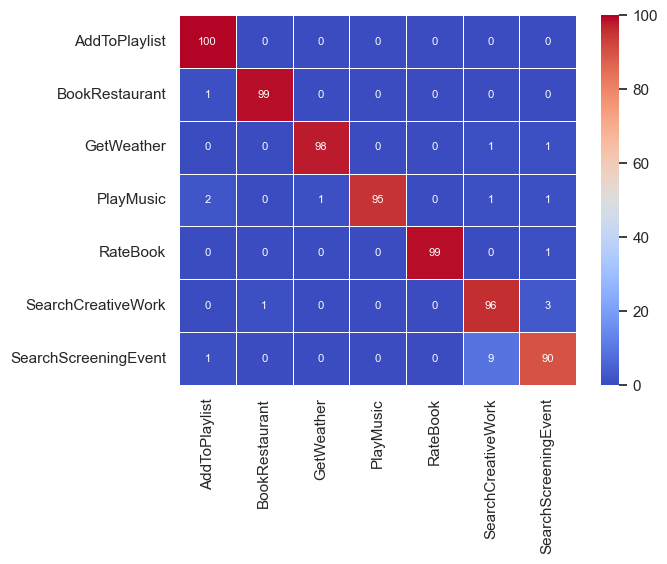

In [105]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [107]:
# Save model
model.save_pretrained('models/bert_tiny')

In [111]:
# Test with a custom sentence
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("models/bert_tiny", num_labels=7)

def int_to_label(intent) :
    if intent == 0:
        return 'AddToPlaylist'
    elif intent == 1:
        return 'BookRestaurant'
    elif intent == 2:
        return 'GetWeather'
    elif intent == 3:
        return 'PlayMusic'
    elif intent == 4:
        return 'RateBook'
    elif intent == 5:
        return 'SearchCreativeWork'
    elif intent == 6:
        return 'SearchScreeningEvent'
    return "Unknown"

def predict(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return int_to_label(predictions[0].item())

sentence = "I want to listen to some music"
print(predict(sentence))

PlayMusic
